```
This file is part of sscx-connectome-manipulations.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# SSCx model order validation
- Fit stochastic 1st-5th order probability models against the five (simplified) rewired connectomes
- Compare them to the respective stochastic probability models fitted against the original connectomes

ℹ️ Part of reproduction of simplified connectomes experiment described in [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- [Connectome-Manipulator](https://github.com/BlueBrain/connectome-manipulator) (Python venv)
- [SSCx network model](https://doi.org/10.5281/zenodo.8026353) (=original circuit)
- Rewired (simplified) circuits, see `SSCx_rewiring.ipynb` (also available in Zenodo dataset)

In [1]:
# Initialization
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from bluepysnap import Circuit
from connectome_manipulator.model_building import model_building, model_types

ℹ️ Set paths below pointing to the original as well as rewired (simplified) circuits

In [3]:
# Circuit base name
circuit_name_base = 'SSCx-HexO1-Release'
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json'  # Released 210K nbS1 (SSCx HexO1) physiology circuit from [Isbister et al. 2023]

# Simplified circuits
order_list = [1, 2, 3, 4, 5]
circuit_names_manip = [f'{circuit_name_base}__ConnRewireOrder{_ord}Hex0EE' for _ord in order_list]
circuit_configs_manip = [f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/circuits/{_nm}/circuit_config.json' for _nm in circuit_names_manip]
circuit_specs_manip = [{'name': _nm, 'config': _cfg} for _nm, _cfg in zip(circuit_names_manip, circuit_configs_manip)]

In [4]:
def export_model_config(model_config, circuit_name, config_path, print_cmd=True):
    """Writes model config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    fn = f'model_config__{model_config["model"]["name"]}__{circuit_name}.json'
    for cpath in config_path:
        if not os.path.exists(cpath):
            os.makedirs(cpath)
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(model_config, f, indent=2)
        # print(f"Config file {fn} written to {cpath}")
    # print(json.dumps(model_config, indent=2))

    if print_cmd:
        # print()
        print_launch_cmd(cpath, fn)

def print_launch_cmd(config_path, config_fn):
    run_cmd = f"sbatch run_model_building.sh {config_fn} --force-reextract --force-rebuild"
    # print(f"# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:")
    # print(f"cd {config_path}")
    print(run_cmd)

ℹ️ Set config and output paths below

In [5]:
# Model building configuration
output_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_validation/'
config_path = '../validation_configs'  # Must exist!

### Prepare & launch validation model building

- Load original model fitting configs
- Writes .json config file for re-extracting same model fits from all five simplified connectomes using `sbatch`

ℹ️ Set model config path below

ℹ️ Configure the SLURM script `run_model_building.sh` according to the used computation system and run below LAUNCH COMMANDS for generating the model fits

ℹ️ All validation model fits are also contained in the Zenodo dataset

In [8]:
model_config_path = '../configs'
model_configs = ['model_config__ConnProb1stOrder-SSCxO1-Hex0EE.json',
                 'model_config__ConnProb2ndOrderComplex-SSCxO1-Hex0EE.json',
                 'model_config__ConnProb3rdOrderComplex-SSCxO1-Hex0EE.json',
                 'model_config__ConnProb4thOrder-SSCxO1-Hex0EE.json',
                 'model_config__ConnProb5thOrder-SSCxO1-Hex0EE.json']

In [9]:
print(f"# LAUNCH COMMANDS:")
print(f"cd {config_path}")

for _fn in model_configs:
    print()
    print(f"# MODEL {os.path.splitext(_fn.split('__')[1])[0]} [CHECK ALLOCATION TIME!!]")
    for _cspec in circuit_specs_manip:
        # Load original model building config
        with open(os.path.join(model_config_path, _fn), 'r') as f:
            _mcfg = json.load(f)

        # Re-define output path
        _mcfg['working_dir'] = os.path.join(output_path, _cspec['name'])
        _mcfg['out_dir'] = _mcfg['working_dir']

        # Re-define circuit
        _mcfg['circuit_config'] = _cspec['config']

        # Write new model building validation config
        export_model_config(_mcfg, _cspec['name'].split('__')[1], config_path)


# LAUNCH COMMANDS:
cd ../validation_configs

# MODEL ConnProb1stOrder-SSCxO1-Hex0EE [CHECK ALLOCATION TIME!!]
sbatch run_model_building.sh model_config__ConnProb1stOrder-SSCxO1-Hex0EE__ConnRewireOrder1Hex0EE.json --force-reextract --force-rebuild
sbatch run_model_building.sh model_config__ConnProb1stOrder-SSCxO1-Hex0EE__ConnRewireOrder2Hex0EE.json --force-reextract --force-rebuild
sbatch run_model_building.sh model_config__ConnProb1stOrder-SSCxO1-Hex0EE__ConnRewireOrder3Hex0EE.json --force-reextract --force-rebuild
sbatch run_model_building.sh model_config__ConnProb1stOrder-SSCxO1-Hex0EE__ConnRewireOrder4Hex0EE.json --force-reextract --force-rebuild
sbatch run_model_building.sh model_config__ConnProb1stOrder-SSCxO1-Hex0EE__ConnRewireOrder5Hex0EE.json --force-reextract --force-rebuild

# MODEL ConnProb2ndOrderComplex-SSCxO1-Hex0EE [CHECK ALLOCATION TIME!!]
sbatch run_model_building.sh model_config__ConnProb2ndOrderComplex-SSCxO1-Hex0EE__ConnRewireOrder1Hex0EE.json --force-reextract --fo

<u>Notes on allocation times</u>:
- `DistDepDelay-SSCxO1-Hex0EE:` 1h allocated, a few minutes running
- `ConnPropsPerPathway-SSCxO1-Hex0EE:` 4h allocated, ~3h running
- `ConnProb1stOrder-SSCxO1-Hex0EE:` 1h allocated, a few minutes running
- `ConnProb2ndOrderComplex-SSCxO1-Hex0EE:` 1h allocated, ~10min running
- `ConnProb3rdOrderComplex-SSCxO1-Hex0EE:` 1h allocated, ~10min running
- `ConnProb4thOrder-SSCxO1-Hex0EE:` 2h allocated, ~1h running
- `ConnProb5thOrder-SSCxO1-Hex0EE:` 16h allocated, ~13h running


### Validate models extracted from simplified connectomes

...by comparing them to the same models extracted from the original connectome

ℹ️ Set paths below pointing to model fitting results folders

In [11]:
# Model paths
orig_model_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_building'
val_model_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_validation'

In [12]:
# Load original circuit
node_set = "hex0"
syn_class = "EXC"
c = Circuit(circuit_config)
nodes = c.nodes["S1nonbarrel_neurons"]
nids = np.intersect1d(nodes.ids(node_set), nodes.ids({"synapse_class": syn_class}))
node_pos = nodes.positions(nids).to_numpy()

#### Validate connection probabilities

- Collect conn. prob. models
- Campare differences of individual probability functions to the ones extracted from original connectome
- Based on connection probabilities probed at different distance/dr/dz/z bins (depending on model order)
- Using mean-squared error (MSE) as error metric

In [13]:
prob_model_names = ['ConnProb1stOrder-SSCxO1-Hex0EE',
                    'ConnProb2ndOrderComplex-SSCxO1-Hex0EE',
                    'ConnProb3rdOrderComplex-SSCxO1-Hex0EE',
                    'ConnProb4thOrder-SSCxO1-Hex0EE',
                    'ConnProb5thOrder-SSCxO1-Hex0EE']

In [14]:
def get_model_conn_prob(model, dist=None, dr=None, dz=None, z=None, do_plot=False):
    mname = model.__class__.__name__

    if dist is not None:
        assert np.all(dist >= 0), 'ERROR: Distance values negative!'

    # Get model probability, depending on model order
    if '1' in mname:  # Constant
        p = model.get_conn_prob()
        if do_plot:
            plt.stem(0, p); plt.xticks([0], labels=[])
    elif '2' in mname:  # Distance-dependent (requires: dist)
        assert dist is not None, 'ERROR: "dist" required!'
        p = model.get_conn_prob(dist)
        if do_plot:
            plt.plot(dist, p)
    elif '3' in mname:  # Bipolar distance-dependent (requires: dist)
        assert dist is not None, 'ERROR: "dist" required!'
        bip_dist = np.unique(np.hstack([np.flip(-dist), dist]))
        p = model.get_conn_prob(np.abs(bip_dist), np.sign(bip_dist))
        if do_plot:
            plt.plot(bip_dist, p)
    elif '4' in mname:  # Offset-dependent (requires: dr, dz)
        assert dr is not None and dz is not None, 'ERROR: "dr" and "dz" required!'
        drv, dzv = np.meshgrid(dr, dz, indexing="ij")
        pos = np.array([drv.flatten(), dzv.flatten()]).T  # Regular grid
        p = model.get_conn_prob(pos[:, 0], pos[:, 1])
        p = p.reshape([len(dr), len(dz)])
        if do_plot:
            plt.imshow(p.T, interpolation="nearest", cmap=plt.cm.hot, vmin=0.0); plt.gca().invert_yaxis()
    elif '5' in mname:  # Position-dependent (requires: dr, dz, z)
        assert dr is not None and dz is not None and z is not None, 'ERROR: "dr", "dz" and "z" required!'
        zv, drv, dzv = np.meshgrid(z, dr, dz, indexing="ij")
        pos = np.array([zv.flatten(), drv.flatten(), dzv.flatten()]).T  # Regular grid
        p = model.get_conn_prob(pos[:, 0], pos[:, 1], pos[:, 2])
        p = p.reshape([len(z), len(dr), len(dz)])
        if do_plot:
            plt.imshow(np.vstack(p).T, interpolation="nearest", cmap=plt.cm.hot, vmin=0.0); plt.gca().invert_yaxis()
    else:
        print('ERROR: Model order unknown!')

    return p

In [15]:
step_size = 10  # Probing step size in um
dist = np.arange(0, 2501, step_size)
dr = np.arange(0, 501, step_size)
dz = np.arange(-1600, 601, step_size)
z = np.arange(-2000, 1, step_size)
p_kwargs = dict(dist=dist, dr=dr, dz=dz, z=z)  # Keyword args for probing probabilities

print('Probing probabilities at...', flush=True)
for _k, _v in p_kwargs.items():
    print(f'  {_k}: {np.min(_v)}..{np.max(_v)} ({len(_v)})', flush=True)

model_errors_mse = np.full((len(prob_model_names), len(circuit_names_manip)), np.nan)

# Loop over models
for i_mod, mname in enumerate(prob_model_names):
    print(f'\nModel "{mname}" validation...', flush=True)
    orig_model = model_types.AbstractModel.model_from_file(os.path.join(orig_model_path, circuit_name_base, 'model', mname + '.json'))
    p_orig = get_model_conn_prob(orig_model, **p_kwargs)

    # Inner loop over circuits
    for i_circ, cname in enumerate(circuit_names_manip):
        print(f'  ...Circuit "{cname}"', flush=True)
        fn = os.path.join(val_model_path, cname, 'model', mname + '.json')
        if not os.path.exists(fn):
            continue
        manip_model = model_types.AbstractModel.model_from_file(fn)
        p_manip = get_model_conn_prob(manip_model, **p_kwargs)

        mse = np.nanmean((p_manip - p_orig)**2)  # Mean squared error
        model_errors_mse[i_mod, i_circ] = mse

Probing probabilities at...
  dist: 0..2500 (251)
  dr: 0..500 (51)
  dz: -1600..600 (221)
  z: -2000..0 (201)

Model "ConnProb1stOrder-SSCxO1-Hex0EE" validation...
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder1Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder2Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder3Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder4Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder5Hex0EE"

Model "ConnProb2ndOrderComplex-SSCxO1-Hex0EE" validation...
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder1Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder2Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder3Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder4Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder5Hex0EE"

Model "ConnProb3rdOrderComplex-SSCxO1-Hex0EE" validation...
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder1Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder2Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder3Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder4Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder5Hex0EE"



Model "ConnProb4thOrder-SSCxO1-Hex0EE" validation...
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder1Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder2Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder3Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder4Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder5Hex0EE"

Model "ConnProb5thOrder-SSCxO1-Hex0EE" validation...
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder1Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder2Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder3Hex0EE"


  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder4Hex0EE"
  ...Circuit "SSCx-HexO1-Release__ConnRewireOrder5Hex0EE"


In [17]:
# Save to file
res_file = os.path.join(val_model_path, 'prob_model_errors.pickle')
res_dict = {'model_errors_mse': model_errors_mse,
            'order_list': order_list,
            'prob_model_names': prob_model_names,
            'circuit_names_manip': circuit_names_manip,
            'p_kwargs': p_kwargs}
with open(res_file, 'wb') as f:
    pickle.dump(res_dict, f)
print(f'Validation results saved to "{res_file}"')

Validation results saved to "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_validation/prob_model_errors.pickle"


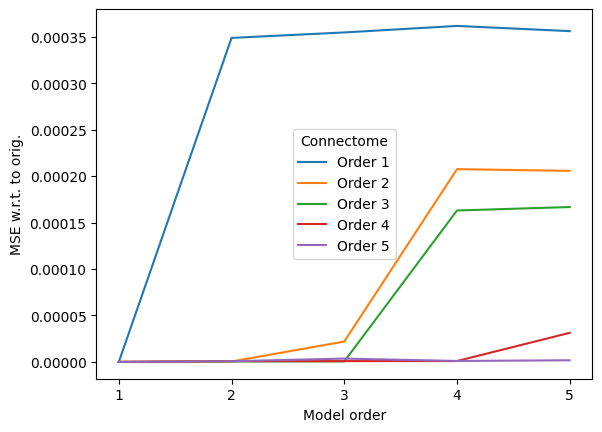

In [18]:
# Plot
plt.figure()
plt.plot(order_list, model_errors_mse)
plt.xticks(order_list)
plt.xlabel('Model order')
plt.ylabel('MSE w.r.t. to orig.')
plt.legend([f'Order {_ord}' for _ord in order_list], title='Connectome')
plt.show()